##### Grading Feedback Cell
104

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import functions as fn
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml import feature
from pyspark.ml import Pipeline
from pyspark.ml import regression
from pyspark.ml import classification
from math import exp #log10, fabs, atan, log
from pyspark.ml.feature import StandardScaler

from pyspark.sql.functions import array_contains, lit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [3]:
# your code here
trans_df = spark.read.option("header","true").option("delimiter","\t").option("inferSchema","true").csv("mooresLaw.txt")

#Printing the first 5 rows of trans_df
trans_df.show(5)
trans_df.printSchema()

#Printing the shape of trans_df (num_rows, num_cols)
print(f"No of rows and columns in trans_df:({trans_df.count()},{len(trans_df.columns)})")

+---------------+------+-----------+----+----+----+----+
|Intel Processor|  Year|Transistors| _c3| _c4| _c5| _c6|
+---------------+------+-----------+----+----+----+----+
|           4004|1971.9|       2300|null|null|null|null|
|           8008|1972.3|       3500|null|null|null|null|
|           8080|1974.3|       6000|null|null|null|null|
|           8085|1976.3|       6500|null|null|null|null|
|           8086|1978.5|      29000|null|null|null|null|
+---------------+------+-----------+----+----+----+----+
only showing top 5 rows

root
 |-- Intel Processor: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Transistors: long (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)

No of rows and columns in trans_df:(74,7)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [4]:
# your code here
#Dropped all columns in trans_df except the Year and Transistors column.
cols_to_be_dropped={'Intel Processor', '_c3', '_c4','_c5','_c6'}
trans_df=trans_df.drop(*cols_to_be_dropped)
trans_df.show(5)


+------+-----------+
|  Year|Transistors|
+------+-----------+
|1971.9|       2300|
|1972.3|       3500|
|1974.3|       6000|
|1976.3|       6500|
|1978.5|      29000|
+------+-----------+
only showing top 5 rows



In [5]:
#Drop rows in trans_df that contain NaN vales
from pyspark.sql.functions import when, count, col,isnan 

In [6]:
#Checking no of NaN values:
print("No of NaN values:")
trans_df.select([count(when(isnan(c), c)).alias(c) for c in trans_df.columns]).show()

#Checking no of Null values:
print("No of NULL values:")
trans_df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           trans_df.columns]).show()

No of NaN values:
+----+-----------+
|Year|Transistors|
+----+-----------+
|   0|          0|
+----+-----------+

No of NULL values:
+----+-----------+
|Year|Transistors|
+----+-----------+
|   0|          0|
+----+-----------+



##### Grading Feedback Cell

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

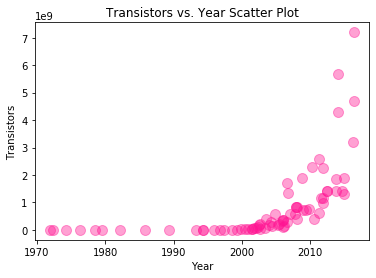

In [7]:
# Your code here
# Convert to Pandas DataFrame  
trans_df.select('Year','Transistors').toPandas().plot(x='Year',y='Transistors',kind='scatter',title="Transistors vs. Year Scatter Plot",s=100,alpha=0.4,color="deeppink")
plt.show()


##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [8]:
# your code here
from pyspark.sql.functions import rand
Correlation =trans_df.stat.corr('Year', 'Transistors')
print(f"Correlation coefficient of trans_df is: {Correlation}")


Correlation coefficient of trans_df is: 0.5434352929286356


##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

Your correlation interpretation here:
Correlation Coefficient: A correlation coefficient is a quantitative assessment that measures both the direction and the strength of this tendency to vary together.

The sign of the correlation coefficient represents the direction of the relationship.
1. With 0.5434352929286356, coefficient is positive which indicates that when the value of one variable increases, the value of the other variable also tends to increase. 

When the value is in-between 0 and +1/-1, there is a relationship. As r approaches -1 or 1,the strength of the relationship increases and the data points tend to fall closer to a line.
2. 0.5434352929286356 a moderate positive relationship since it is closer to (0.6-1 range). 




##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [9]:
#Creating a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
trans_df_2 = trans_df.select('Year', 'Transistors',fn.log('Transistors').alias('Transistors_Log'))

#The head of trans_df_2
print(f"Head of the trans_df_2:\n{trans_df_2.head(1)}\n")

#The shape of trans_df_2
print(f"Shape of the trans_df_2:({trans_df_2.count()},{len(trans_df_2.columns)})")


Head of the trans_df_2:
[Row(Year=1971.9, Transistors=2300, Transistors_Log=7.7406644019172415)]

Shape of the trans_df_2:(74,3)


##### Grading Feedback Cell
-1 for not printing the head of the dataframe correctly

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

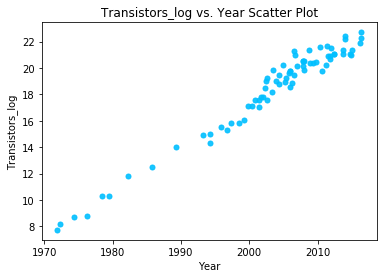

In [10]:
#Scatter plot of log transistors vs. year.
trans_df_2.select('Year','Transistors_log').toPandas().plot(x='Year',y='Transistors_log',kind='scatter',title="Transistors_log vs. Year Scatter Plot",s=25,alpha=0.9,color="deepskyblue")
plt.show()

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [11]:
#Splitting trans_df_2 into train and test splits with a 60:40 ratio.
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
trans_train,trans_test = trans_df_2.randomSplit([0.6, 0.4], seed=12345)

In [12]:
#Shape of of the train and test data frames.

print(f"Shape of trans_train:({trans_train.count()},{len(trans_train.columns)})")
trans_train.show(2)
print(f"Shape of trans_test:({trans_test.count()},{len(trans_test.columns)})")
trans_test.show(2)


Shape of trans_train:(49,3)
+------+-----------+------------------+
|  Year|Transistors|   Transistors_Log|
+------+-----------+------------------+
|1971.9|       2300|7.7406644019172415|
|1972.3|       3500| 8.160518247477505|
+------+-----------+------------------+
only showing top 2 rows

Shape of trans_test:(25,3)
+------+-----------+------------------+
|  Year|Transistors|   Transistors_Log|
+------+-----------+------------------+
|1978.5|      29000|10.275051108968611|
|1979.5|      29000|10.275051108968611|
+------+-----------+------------------+
only showing top 2 rows



##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [13]:
# your code here

trans_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['_features'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='_features', featuresCol='features')])





fitted_trans_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['Year'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='Transistors', featuresCol='features')]).fit(trans_train)


log_fitted_trans_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['Year'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='Transistors_Log', featuresCol='features')]).fit(trans_train)


##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [14]:
# your code here
print("For fitted_trans_pipe:\n") 
coefficient = fitted_trans_pipe.stages[1].coefficients
print(f"The linear regression coefficient in the linear regression object is:\t \n{coefficient}")
intercept = fitted_trans_pipe.stages[1].intercept
print(f"The linear regression Y intercept in the linear regression object is:\t \n{intercept}\n")


print("For log_fitted_trans_pipe:\n")
coefficient = log_fitted_trans_pipe.stages[1].coefficients
print(f"The linear regression coefficient in the linear regression object is:\t \n{coefficient}")
intercept = log_fitted_trans_pipe.stages[1].intercept
print(f"The linear regression Y intercept in the linear regression object is:\t \n{intercept}")




For fitted_trans_pipe:

The linear regression coefficient in the linear regression object is:	 
[64462706.310680375]
The linear regression Y intercept in the linear regression object is:	 
-128294241828.26088

For log_fitted_trans_pipe:

The linear regression coefficient in the linear regression object is:	 
[0.339246771291069]
The linear regression Y intercept in the linear regression object is:	 
-661.1615269651243


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [15]:
# your code here
mse1 = fn.mean((fn.col('Transistors') - fn.col('prediction'))**2).alias('mse1')
mse2 = fn.mean((fn.col('Transistors_log') - fn.col('prediction'))**2).alias('mse2')

print(f"The MSE for fitted_trans_pipe is:")
fitted_trans_pipe.transform(trans_test).select(mse1).show()

print(f"The MSE for log_fitted_trans_pipe is:")
log_fitted_trans_pipe.transform(trans_test).select(mse2).show()

The MSE for fitted_trans_pipe is:
+--------------------+
|                mse1|
+--------------------+
|1.001273219877531...|
+--------------------+

The MSE for log_fitted_trans_pipe is:
+------------------+
|              mse2|
+------------------+
|0.5249044040063555|
+------------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [16]:
t_1970 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1970)
t_1980 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1980)
t_1990 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1990)
t_2000 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2000)
t_2010 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2010)
print("Number of Transistors for year 1970: ",t_1970)
print("Number of Transistors for year 1980: ",t_1980)
print("Number of Transistors for year 1990: ",t_1990)
print("Number of Transistors for year 2000: ",t_2000)
print("Number of Transistors for year 2010: ",t_2010)


Number of Transistors for year 1970:  1279.9963153563986
Number of Transistors for year 1980:  38066.13006963507
Number of Transistors for year 1990:  1132058.1482104317
Number of Transistors for year 2000:  33666559.97300641
Number of Transistors for year 2010:  1001218234.423432


##### Grading Feedback Cell

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [17]:
# your code here
# your code here
global_warm_df = spark.read.option("header","true").option("delimiter","\t").option("inferSchema","true").csv("globalWarm.txt")

#Printing the first 5 rows of trans_df
global_warm_df.show(5)
global_warm_df.printSchema()

#Printing the shape of trans_df (num_rows, num_cols)
print(f"No of rows and columns in trans_df:({global_warm_df.count()},{len(global_warm_df.columns)})")

+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43| 0.928466667|     7.2|
|1980|  19|338.57|1366.51| 0.929666667|    7.85|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|
|1982|   4| 341.3|1366.16| 0.853066667|    7.45|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|
+----+----+------+-------+------------+--------+
only showing top 5 rows

root
 |-- Year: integer (nullable = true)
 |-- Temp: integer (nullable = true)
 |-- CO2: double (nullable = true)
 |-- Solar: double (nullable = true)
 |-- Transmission: double (nullable = true)
 |-- IceShelf: double (nullable = true)

No of rows and columns in trans_df:(32,6)


##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

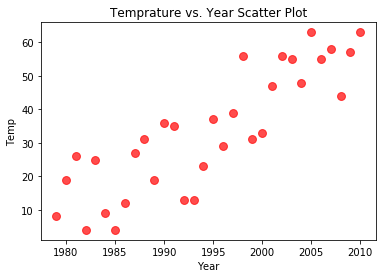

In [18]:
# Convert to Pandas DataFrame  
global_warm_df.select('Year','Temp').toPandas().plot(x='Year',y='Temp',kind='scatter',s=250,alpha=0.7,marker=".",color="red");
plt.title("Temprature vs. Year Scatter Plot")
plt.show()

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

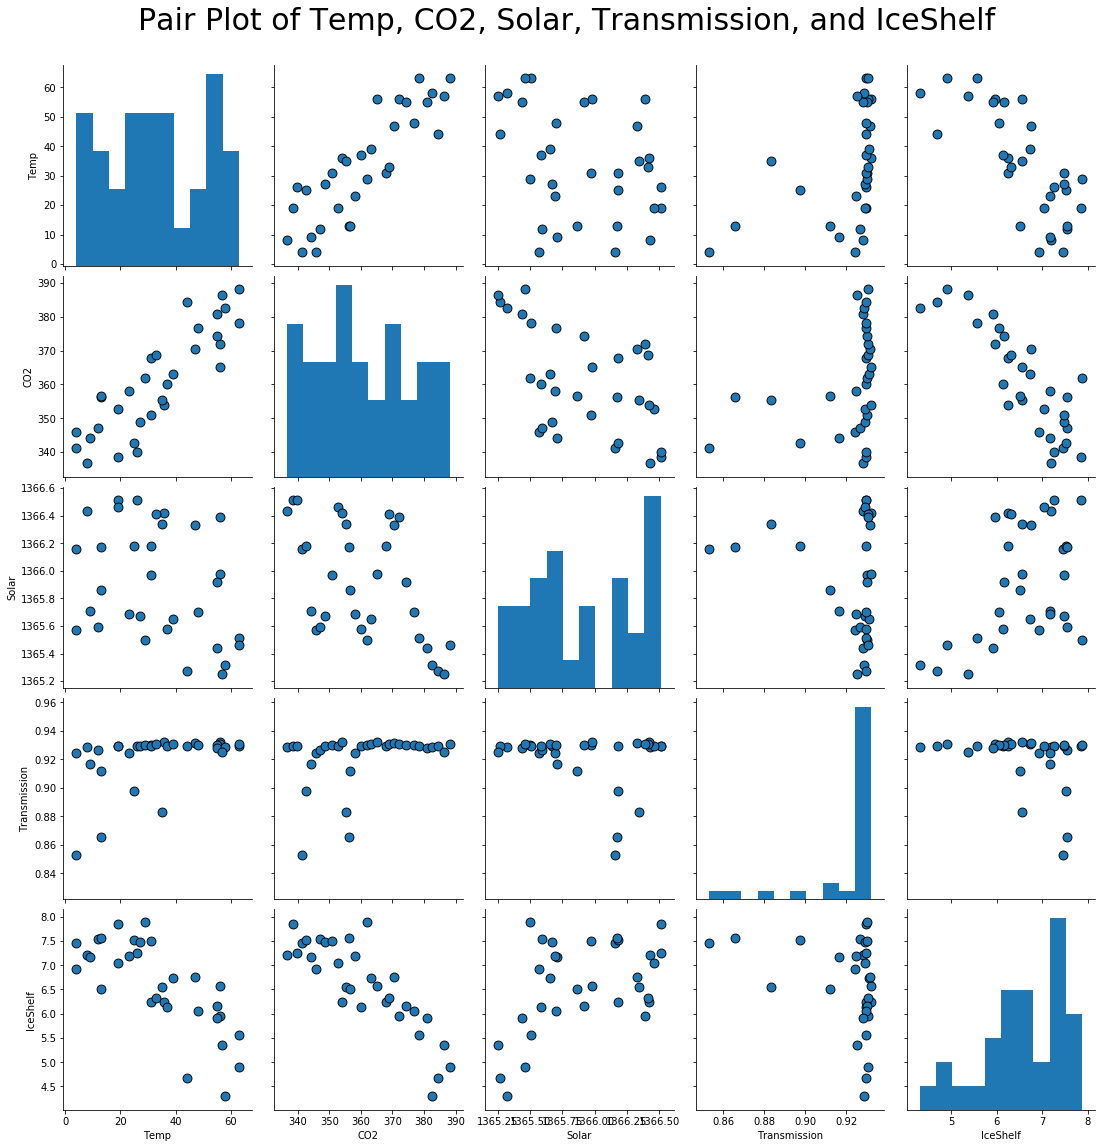

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
x=sns.pairplot(global_warm_df.toPandas(),
            vars = ['Temp','CO2','Solar','Transmission','IceShelf'],
                 kind = "scatter",palette = "gist_heat",height=3,plot_kws=dict(s=80, edgecolor="black", linewidth=0.9));
                  
x.fig.suptitle('Pair Plot of Temp, CO2, Solar, Transmission, and IceShelf',size=30,y=1.05)
plt.show()

##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [20]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

global_warm_df_wo_year=global_warm_df.drop(global_warm_df.Year)
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=global_warm_df_wo_year.columns, outputCol=vector_col)
df_vector = assembler.transform(global_warm_df_wo_year).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

#Print a labeled correlation matrix.
from matplotlib import pyplot as plt

result = matrix.collect()[0]["pearson({})".format(vector_col)].values
x=pd.DataFrame(result.reshape(-1, len(global_warm_df_wo_year.columns)), columns=global_warm_df_wo_year.columns, index=global_warm_df_wo_year.columns)
x.style.background_gradient(cmap='GnBu')\
.set_caption("Correlation Matrix:")


,Temp,CO2,Solar,Transmission,IceShelf
Temp,1.000000,0.860927,-0.340342,0.435394,-0.747425
CO2,0.860927,1.000000,-0.542822,0.328228,-0.846961
Solar,-0.340342,-0.542822,1.000000,-0.205848,0.470690
Transmission,0.435394,0.328228,-0.205848,1.000000,-0.302484
IceShelf,-0.747425,-0.846961,0.470690,-0.302484,1.000000


##### Grading Feedback Cell

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [21]:
# your code here
gw_train,gw_test = global_warm_df.randomSplit([0.6, 0.4],seed=3124)
print(f"No of rows and columns in gw_train:({gw_train.count()},{len(gw_train.columns)})")
gw_train.show(1)
print(f"No of rows and columns in gw_test:({gw_test.count()},{len(gw_test.columns)})")
gw_test.show(1)

No of rows and columns in gw_train:(18,6)
+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43| 0.928466667|     7.2|
+----+----+------+-------+------------+--------+
only showing top 1 row

No of rows and columns in gw_test:(14,6)
+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1981|  26|339.92|1366.51| 0.929766667|    7.25|
+----+----+------+-------+------------+--------+
only showing top 1 row



##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [22]:
# your code here
global_warm_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['features'],outputCol='_features'),
                                    regression.LinearRegression(labelCol='_features', featuresCol='features')])





fitted_global_warm_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['CO2'],outputCol='features'),
                                     regression.LinearRegression(labelCol='Temp', featuresCol='features')]).fit(gw_train)


fitted_global_warm_pipe_2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'],outputCol ='features'),
                                         regression.LinearRegression(labelCol='Temp', featuresCol='features')]).fit(gw_train)


##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [23]:
print("1. For fitted_global_warm_pipe:\n") 
coefficient = fitted_global_warm_pipe.stages[1].coefficients
print(f"The linear regression coefficient in the linear regression object is:\t \n{coefficient}")
intercept = fitted_global_warm_pipe.stages[1].intercept
print(f"The linear regression Y intercept in the linear regression object is:\t \n{intercept}\n")


print("2. For fitted_global_warm_pipe_2:\n")
coefficient = fitted_global_warm_pipe_2.stages[1].coefficients
print(f"The linear regression coefficient in the linear regression object is:\t \n{coefficient}")
intercept = fitted_global_warm_pipe_2.stages[1].intercept
print(f"The linear regression Y intercept in the linear regression object is:\t \n{intercept}")





1. For fitted_global_warm_pipe:

The linear regression coefficient in the linear regression object is:	 
[1.1648028839352298]
The linear regression Y intercept in the linear regression object is:	 
-387.9592557134493

2. For fitted_global_warm_pipe_2:

The linear regression coefficient in the linear regression object is:	 
[1.0439292775046256,7.413572883670887,147.84569129655313,-3.2103251087357108]
The linear regression Y intercept in the linear regression object is:	 
-10585.251010387554


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [24]:
# your code here
mse3 = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse3')
mse4 = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse4')


print(f"The MSE for fitted_global_warm_pipe is:")
fitted_global_warm_pipe.transform(gw_test).select(mse3).show()

print(f"The MSE for fitted_global_warm_pipe_2 is:")
fitted_global_warm_pipe_2.transform(gw_test).select(mse4).show()

The MSE for fitted_global_warm_pipe is:
+------------------+
|              mse3|
+------------------+
|103.23909089471228|
+------------------+

The MSE for fitted_global_warm_pipe_2 is:
+-----------------+
|             mse4|
+-----------------+
|91.02713441248662|
+-----------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

Mean Squared Error (mse4) is lower of the model that includes all the features . 
The fit of the model is improving due to increasing the number of features which is reducing the bias as well.Therefore, predicted values are closer to the actual values. 

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [25]:
# your code here
va_pipe2 = feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'], outputCol='features_all')

scaler = StandardScaler(inputCol = 'features_all', outputCol="scaledFeatures",withStd=True, withMean=True)
lr_global_warm_all_scaled = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='Temp')
global_warm_pipe_all_std = Pipeline(stages=[va_pipe2,scaler, lr_global_warm_all_scaled])
fitted_global_warm_pipe_3 = global_warm_pipe_all_std.fit(gw_train)
print("Intercept of the model is: ",fitted_global_warm_pipe_3.stages[2].intercept)
print("Coefficient of CO2 is: ",fitted_global_warm_pipe_3.stages[2].coefficients[0])
print("Coefficient of Solar is: ",fitted_global_warm_pipe_3.stages[2].coefficients[1])
print("Coefficient of Transmission is: ",fitted_global_warm_pipe_3.stages[2].coefficients[2])
print("Coefficient of IceShelf is: ",fitted_global_warm_pipe_3.stages[2].coefficients[3])

Intercept of the model is:  32.33333333333247
Coefficient of CO2 is:  15.420654847355056
Coefficient of Solar is:  3.189633221811795
Coefficient of Transmission is:  3.5660235114455663
Coefficient of IceShelf is:  -2.994619107667793


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

Coefficient inference conclusions here:
As observed, When there will be an increase in these positive coefficients (CO2,Solar,Transmission), there will be an increase in Temperature while an increase in Ice Shelf will result in a Temperature drop.
1. When all the variables are 0, the temperature is going to be equal to the 32.3333.
2. When IceShelf increases by 1 standard deviation the temperature is going to decrease by 2.9946 units
3. With every 1 standard deviation increase in Transmission, keeping all the other variables constant will result in 3.5660 units increase in temperature.

##### Grading Feedback Cell

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [26]:
# functions:

def times_3(el):
    return el*3
    
def is_even(el):
    if el%2 == 0:
        return True
    else:
        return False

def my_sum(a,b):
    c = (a,b)
    return sum(c)

In [27]:
# simple rdd class
class rdd:
    def __init__(self, arg_array):
        self.local_array = arg_array
    
    
    def my_map(self, fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        
    
        mapped = np.empty_like(self.local_array)
        
        for i, el in enumerate(self.local_array):
            
            mapped[i] = fun(self.local_array[i])
        return rdd(mapped)
    
    
    def my_filter(self, fun):
        # create a temporary list to store the filtered results
        transformed = []

        for el in self.local_array:
            if fun(el):
                transformed.append(el)
                
        return rdd(np.array(transformed))
    
    
    def my_reduce(self,fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        total = 0
        for i, el in enumerate(self.local_array):
            if(i%2 ==0):
                total = total+fun(self.local_array[i],self.local_array[i+1])
        return total
            
    
    def collect(self):
        return self.local_array

In [28]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)

# secret grading test code follows


<class 'numpy.int64'>
7350


##### Grading Feedback Cell
-5 for assumed integer in the algorithm